Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# Import libs
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import math
from math import nan
import random
import json
from future.utils import iteritems
import pickle
from requests import get

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode

!pip install transformers

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.1 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=f1737c8383b83730b73b36d734288ba8e3d9ebce0a925bb1d19ecfb42940f03c
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 27.7 MB/s 


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1hIe1NaUcYENwTFrG_z1WUEiEkEzhtzbx'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fbR_cCVnnvMiJuaS7tvGE8nHHepciFuG'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1cz6lxw3dd-zeoKtLewT7pjSkIIh4BjOe'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="utf-8")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="utf-8")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="utf-8")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  226
Number of dev sentences:  40
Number of test sentences:  48
Number of words in the training dataset:  5862
Number of words in the dev dataset:  1874
Number of words in the test dataset:  2030
Tags in the training dataset: ['B-AGMT_DATE', 'I-DOC_NAME', 'B-DOC_NAME', 'B-PARTY', 'I-PARTY', 'O', 'I-AGMT_DATE']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-AGMT_DATE', 'I-DOC_NAME', 'B-DOC_NAME', 'B-PARTY', 'I-PARTY', 'O', 'I-AGMT_DATE']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-AGMT_DATE', 'I-DOC_NAME', 'B-DOC_NAME', 'B-PARTY', 'I-PARTY', 'O', 'I-AGMT_DATE']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Exhibit,O
1,Sentence: 1,99.1,O
2,Sentence: 1,JOINT,B-DOC_NAME
3,Sentence: 1,FILING,I-DOC_NAME
4,Sentence: 1,AGREEMENT,I-DOC_NAME
5,Sentence: 1,The,O
6,Sentence: 1,undersigned,O
7,Sentence: 1,hereby,O
8,Sentence: 1,agree,O
9,Sentence: 1,that,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Exhibit', 'O'),
 ('10.8', 'O'),
 ('Services', 'B-DOC_NAME'),
 ('Agreement', 'I-DOC_NAME'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('and', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 ('(', 'I-PARTY'),
 ('International', 'I-PARTY'),
 (')', 'I-PARTY'),
 ('Limited', 'I-PARTY'),
 ('September', 'O'),
 ('2018', 'O'),
 ('1', 'O'),
 ('THIS', 'O'),
 ('SERVICES', 'B-DOC_NAME'),
 ('AGREEMENT', 'I-DOC_NAME'),
 ('(', 'O'),
 ('this', 'O'),
 ('“', 'O'),
 ('Agreement', 'O'),
 ('”', 'O'),
 (')', 'O'),
 ('is', 'O'),
 ('made', 'O'),
 ('on', 'O'),
 ('25', 'B-AGMT_DATE'),
 ('September', 'I-AGMT_DATE'),
 ('2018', 'I-AGMT_DATE'),
 ('BETWEEN', 'O'),
 (':', 'O'),
 ('(', 'O'),
 ('1', 'O'),
 (')', 'O'),
 ('Oaktree', 'B-PARTY'),
 ('Capital', 'I-PARTY'),
 ('Management', 'I-PARTY'),
 (',', 'I-PARTY'),
 ('L.P.', 'I-PARTY'),
 ('a', 'O'),
 ('Delaware', 'O'),
 ('limited', 'O'),
 ('partnership', 'O

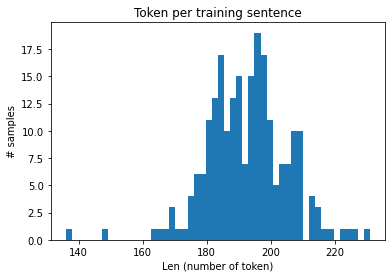

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

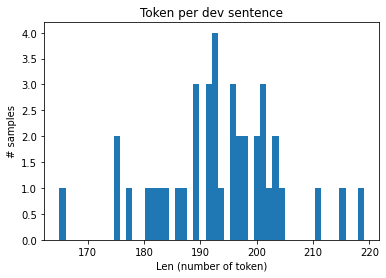

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

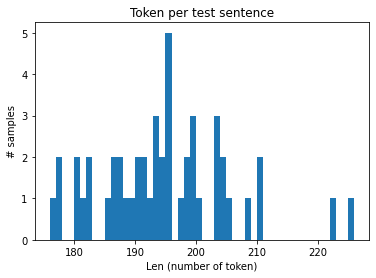

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in iteritems(word2idx)}

tag2idx = {t: i for i, t in enumerate(tags)}

idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'business'
print(word2idx['business'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-PARTY'
print(tag2idx['B-PARTY'])
# Tag of index 2
print(idx2tag[2])

5721
distribut
5
I-PARTY


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
# X_train, y_train = random_remove_data_points(X_train, y_train, 0.9964)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 226
Points in y_train before removal: 226
Points in X_train before removal: 226
Points in y_train before removal: 226


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1082, 7083, 1657, 4332, 4592, 1097, 231, 1547, 292, 1170, 6043, 6985, 5258, 7206, 5594, 7182, 1256, 5087, 6043, 1738, 5679, 1398, 5594, 3976, 6305, 6921, 2964, 376, 6200, 5890, 5922, 149, 6921, 5679, 1097, 3916, 5260, 3518, 6921, 4115, 4942, 5679, 5005, 6131, 6921, 3150, 6921, 1403, 6921, 534, 2189, 3776, 6984, 4709, 5236, 3776, 5316, 6985, 3520, 3499, 3216, 3030, 2399, 5679, 6043, 231, 6294, 6820, 6921, 899, 5316, 4936, 5679, 2399, 5679, 5299, 6204, 5087, 534, 293, 5546, 7182, 6043, 6026, 5679, 1690, 214, 3499, 6715, 6043, 347, 1652, 142, 5679, 2584, 6921, 4942, 1099, 4056, 6432, 3341, 6921, 1911, 4709, 6879, 3499, 6460, 6318, 6603, 1560, 6488, 3031, 4709, 2, 3499, 1560, 6488, 3031, 6921, 1436, 4709, 5192, 7206, 550, 3499, 861, 6488, 6969, 6603, 1560, 6488, 3031, 4709, 2, 3499, 6402]
[1, 1, 6, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1W3P_xzWN4P3YTFvHqw0wY-PUClLXne1K'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['business'])
print(tag2idx['B-PARTY'])
print(idx2tag[2])
print(idx2word[10])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 989 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=b2156891bebfccfc0cd8ced80b44a1bbc3ecd82b3d8fb0736812dfd0ee5207fb
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 1.9 MB/s 
     |████████████████████████████████| 120 kB 74.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.1 MB/s 
[1082, 7083, 1657, 4332, 4592, 1097, 231, 1547, 292, 1170, 6

In [ ]:
from transformers import pipeline
from future.utils import iteritems

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='bert-base-multilingual-cased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]
      replaceable_indices = [i for i,label in enumerate(base_labels[k]) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != sequence_str[index]]
        new_word = random.choice(available_words)
        augmented_sentence[index] = new_word

      # print("Original text->",sequence_str)
      # print("Augmented text->",augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(base_labels[k])

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

In [ ]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-09-23 20:46:45--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-23 20:46:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-23 20:46:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [ ]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [ ]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [ ]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [ ]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [ ]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3075 words (4869 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 231, 100)          794500    
                                                                 
 bidirectional_4 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 956,756
Trainable params: 956,756
Non-trainable param

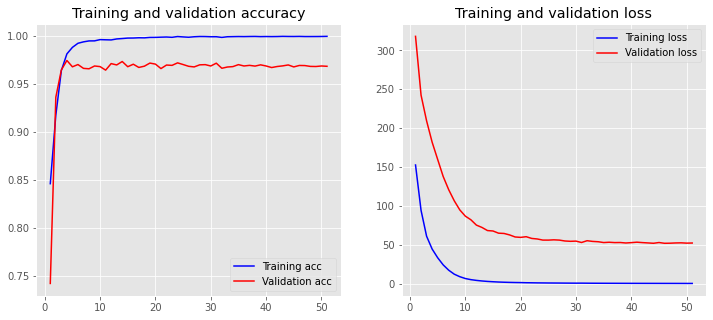

2/2 [==============================] - 3s 65ms/step
F1-score: 70.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8627450980392157,0.88,0.8712871287128714,50.0
DOC_NAME,0.7764705882352941,0.8048780487804879,0.7904191616766466,82.0
PARTY,0.5416666666666666,0.6290322580645161,0.582089552238806,124.0
micro avg,0.6714285714285714,0.734375,0.7014925373134329,256.0
macro avg,0.7269607843137255,0.7713034356150014,0.7479319475427747,256.0
weighted avg,0.6795879289215686,0.734375,0.7053040319169552,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3070 words (4855 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 231, 100)          792600    
                                                                 
 bidirectional_5 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 954,856
Trainable params: 954,856
Non-trainable param

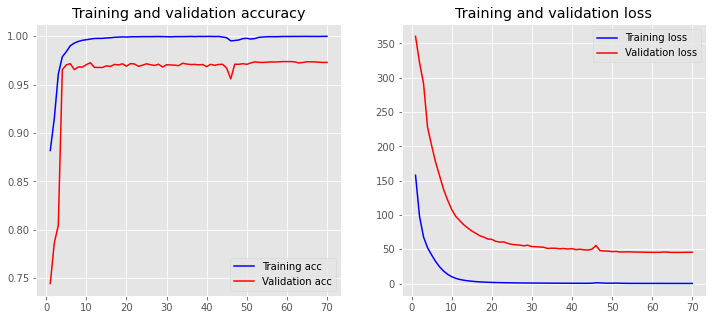

2/2 [==============================] - 3s 57ms/step
F1-score: 80.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8679245283018868,0.92,0.8932038834951457,50.0
DOC_NAME,0.8518518518518519,0.8414634146341463,0.8466257668711655,82.0
PARTY,0.7307692307692307,0.7661290322580645,0.748031496062992,124.0
micro avg,0.7954545454545454,0.8203125,0.8076923076923076,256.0
macro avg,0.8168485369743231,0.8425308156307368,0.8292870488097678,256.0
weighted avg,0.7963416518841047,0.8203125,0.8079664553515775,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3072 words (4863 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 231, 100)          793600    
                                                                 
 bidirectional_6 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 955,856
Trainable params: 955,856
Non-trainable param

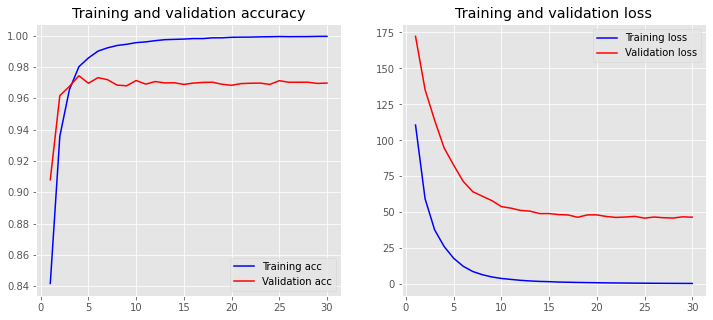

2/2 [==============================] - 3s 63ms/step
F1-score: 76.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8461538461538461,0.88,0.8627450980392156,50.0
DOC_NAME,0.8048780487804879,0.8048780487804879,0.8048780487804877,82.0
PARTY,0.6953125,0.717741935483871,0.7063492063492064,124.0
micro avg,0.7595419847328244,0.77734375,0.7683397683397684,256.0
macro avg,0.7821147983114446,0.8008733280881196,0.79132411772297,256.0
weighted avg,0.7598689152644231,0.77734375,0.7684552987861811,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3064 words (4868 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 231, 100)          793300    
                                                                 
 bidirectional_7 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 955,556
Trainable params: 955,556
Non-trainable param

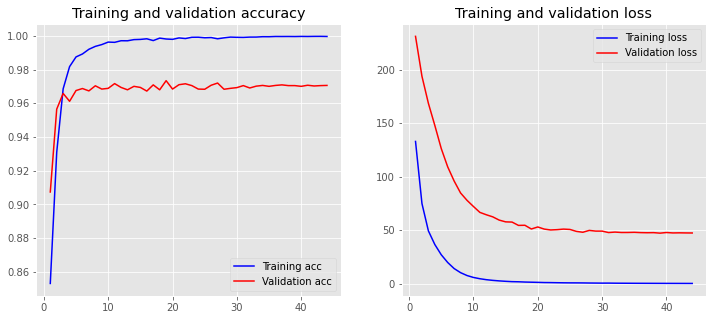

2/2 [==============================] - 3s 60ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8653846153846154,0.9,0.8823529411764707,50.0
DOC_NAME,0.7976190476190477,0.8170731707317073,0.8072289156626505,82.0
PARTY,0.6423357664233577,0.7096774193548387,0.6743295019157088,124.0
micro avg,0.7326007326007326,0.78125,0.7561436672967863,256.0
macro avg,0.7684464764756735,0.808916863362182,0.7879704529182767,256.0
weighted avg,0.7356391707440978,0.78125,0.7575284233621437,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3069 words (4877 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 231, 100)          794700    
                                                                 
 bidirectional_8 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 956,956
Trainable params: 956,956
Non-trainable param

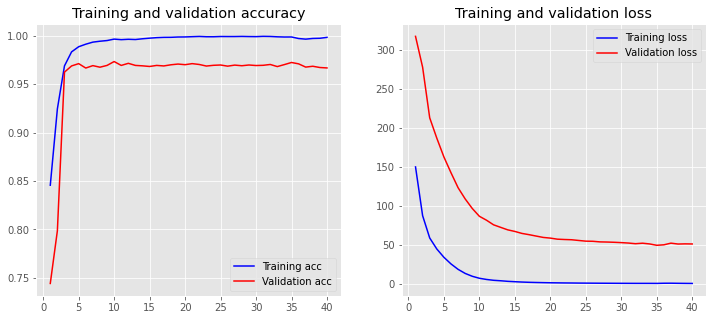

2/2 [==============================] - 3s 65ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8181818181818182,0.9,0.8571428571428572,50.0
DOC_NAME,0.8048780487804879,0.8048780487804879,0.8048780487804877,82.0
PARTY,0.575,0.7419354838709677,0.6478873239436619,124.0
micro avg,0.6835016835016835,0.79296875,0.7341772151898734,256.0
macro avg,0.7326866223207688,0.8156045108838187,0.769969409955669,256.0
weighted avg,0.6961292613636363,0.79296875,0.7390436368209256,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3065 words (4868 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 231, 100)          793400    
                                                                 
 bidirectional_9 (Bidirectio  (None, 231, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 231, 7)           1407      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 231, 7)            49        
                                                                 
Total params: 955,656
Trainable params: 955,656
Non-trainable para

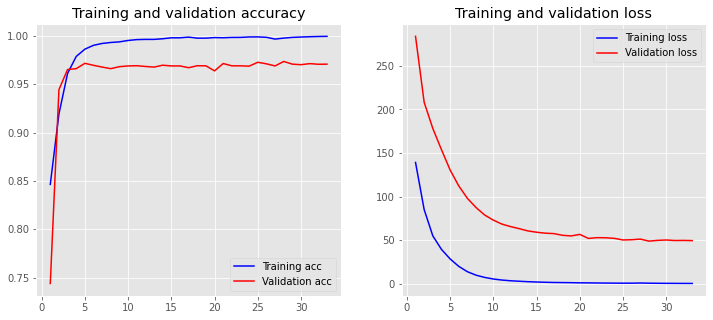

2/2 [==============================] - 3s 60ms/step
F1-score: 75.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8301886792452831,0.88,0.8543689320388349,50.0
DOC_NAME,0.7922077922077922,0.7439024390243902,0.7672955974842767,82.0
PARTY,0.6595744680851063,0.75,0.7018867924528301,124.0
micro avg,0.7306273062730627,0.7734375,0.7514231499051233,256.0
macro avg,0.7606569798460606,0.7913008130081302,0.7745171073253139,256.0
weighted avg,0.7353816678353762,0.7734375,0.752619718202357,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3061 words (4870 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 231, 100)          793200    
                                                                 
 bidirectional_10 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 955,456
Trainable params: 955,456
Non-trainable para

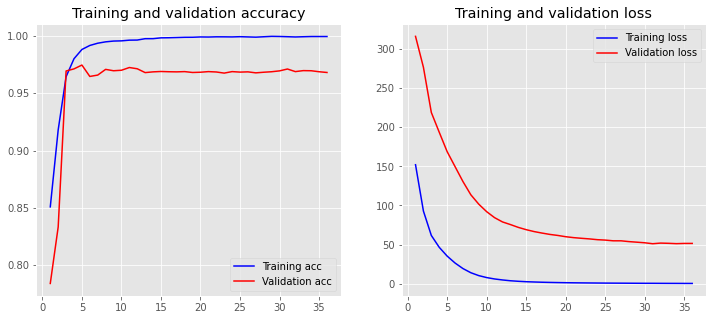

2/2 [==============================] - 3s 66ms/step
F1-score: 75.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8653846153846154,0.9,0.8823529411764707,50.0
DOC_NAME,0.7674418604651163,0.8048780487804879,0.7857142857142858,82.0
PARTY,0.6496350364963503,0.717741935483871,0.681992337164751,124.0
micro avg,0.7272727272727273,0.78125,0.7532956685499059,256.0
macro avg,0.7608205041153607,0.8075399947547863,0.7833531880185025,256.0
weighted avg,0.72950862442546,0.78125,0.7543487042805629,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3081 words (4853 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 231, 100)          793500    
                                                                 
 bidirectional_11 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 955,756
Trainable params: 955,756
Non-trainable para

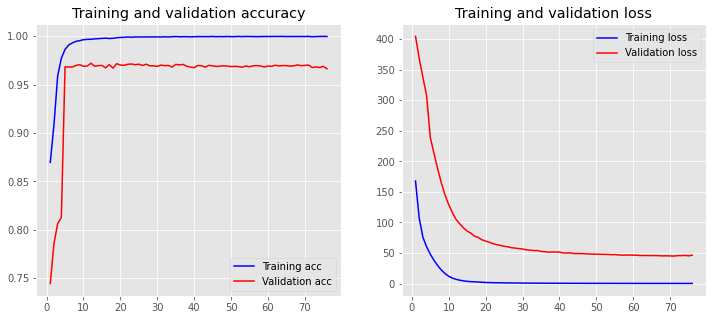

2/2 [==============================] - 3s 66ms/step
F1-score: 72.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7962962962962963,0.86,0.826923076923077,50.0
DOC_NAME,0.7471264367816092,0.7926829268292683,0.7692307692307693,82.0
PARTY,0.6115107913669064,0.6854838709677419,0.6463878326996197,124.0
micro avg,0.6892857142857143,0.75390625,0.7201492537313432,256.0
macro avg,0.7183111748149372,0.7793889325990034,0.7475138929511553,256.0
weighted avg,0.6910410967203249,0.75390625,0.7209967506946475,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3069 words (4873 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 231, 100)          794300    
                                                                 
 bidirectional_12 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 956,556
Trainable params: 956,556
Non-trainable para

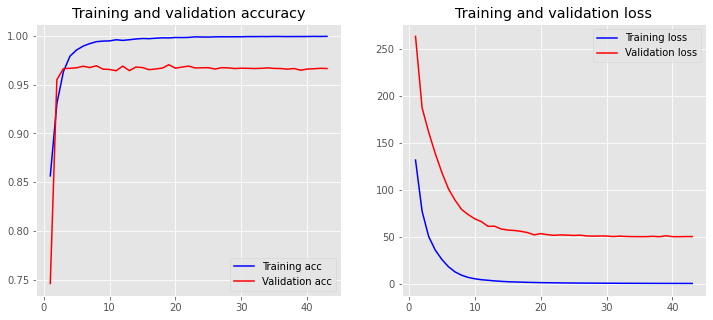

2/2 [==============================] - 3s 67ms/step
F1-score: 74.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8490566037735849,0.9,0.8737864077669903,50.0
DOC_NAME,0.788235294117647,0.8170731707317073,0.8023952095808382,82.0
PARTY,0.6390977443609023,0.6854838709677419,0.6614785992217899,124.0
micro avg,0.7269372693726938,0.76953125,0.747628083491461,256.0
macro avg,0.758796547417378,0.8008523472331497,0.7792200721898728,256.0
weighted avg,0.7278759554963992,0.76953125,0.748082319833907,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 283
Points in y_train after augmentation: 283
Converted 3069 words (4859 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 231, 100)          792900    
                                                                 
 bidirectional_13 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 955,156
Trainable params: 955,156
Non-trainable para

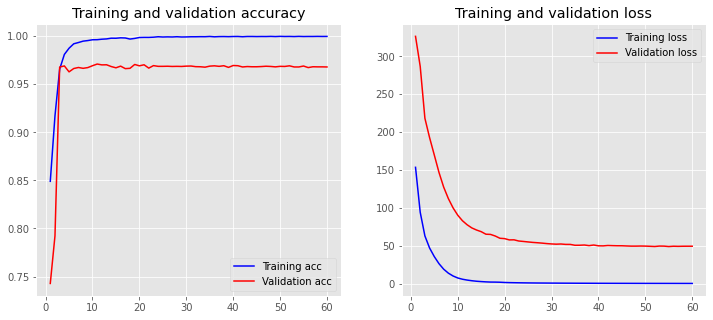

2/2 [==============================] - 3s 68ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7924528301886793,0.84,0.8155339805825242,50.0
DOC_NAME,0.7647058823529411,0.7926829268292683,0.7784431137724551,82.0
PARTY,0.5942028985507246,0.6612903225806451,0.6259541984732824,124.0
micro avg,0.6847826086956522,0.73828125,0.7105263157894737,256.0
macro avg,0.7171205370307817,0.7646577498033045,0.7399770976094207,256.0
weighted avg,0.6875378253229101,0.73828125,0.71182560534826,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3092 words (4917 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 231, 100)          801000    
                                                                 
 bidirectional_14 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 963,256
Trainable params: 963,256
Non-trainable para

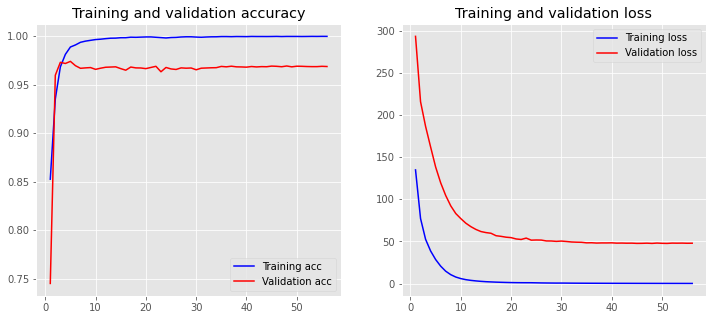

2/2 [==============================] - 3s 61ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8235294117647058,0.84,0.8316831683168315,50.0
DOC_NAME,0.7976190476190477,0.8170731707317073,0.8072289156626505,82.0
PARTY,0.6090225563909775,0.6532258064516129,0.6303501945525293,124.0
micro avg,0.7089552238805971,0.7421875,0.7251908396946565,256.0
macro avg,0.7433903385915771,0.7700996590611067,0.7564207595106703,256.0
weighted avg,0.71132824017765,0.7421875,0.7263295063464552,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3119 words (4928 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 231, 100)          804800    
                                                                 
 bidirectional_15 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 967,056
Trainable params: 967,056
Non-trainable para

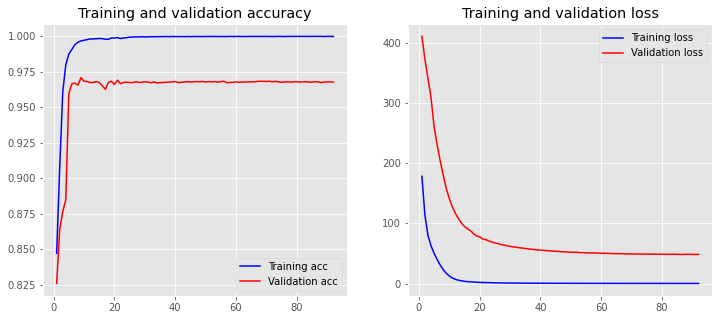

2/2 [==============================] - 3s 62ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7543859649122807,0.86,0.8037383177570094,50.0
DOC_NAME,0.7804878048780488,0.7804878048780488,0.7804878048780488,82.0
PARTY,0.5753424657534246,0.6774193548387096,0.6222222222222222,124.0
micro avg,0.6701754385964912,0.74609375,0.7060998151571165,256.0
macro avg,0.703405411847918,0.7726357199055861,0.7354827816190935,256.0
weighted avg,0.6760225156212448,0.74609375,0.7083690290758048,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3100 words (4916 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 231, 100)          801700    
                                                                 
 bidirectional_16 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 963,956
Trainable params: 963,956
Non-trainable para

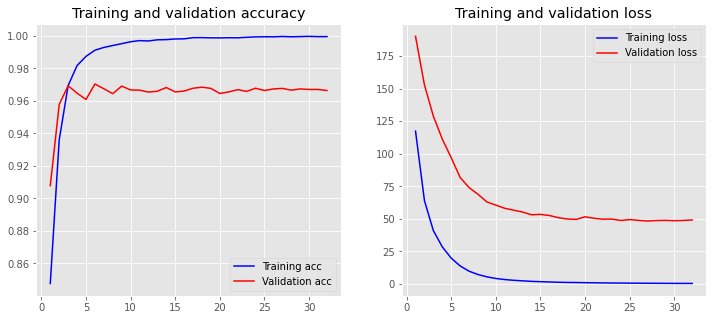

2/2 [==============================] - 3s 63ms/step
F1-score: 74.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8627450980392157,0.88,0.8712871287128714,50.0
DOC_NAME,0.7764705882352941,0.8048780487804879,0.7904191616766466,82.0
PARTY,0.6776859504132231,0.6612903225806451,0.6693877551020408,124.0
micro avg,0.7470817120622568,0.75,0.7485380116959064,256.0
macro avg,0.7723005455625777,0.7820561237870444,0.7770313484971862,256.0
weighted avg,0.745472269486307,0.75,0.7475890989288345,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3093 words (4913 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 231, 100)          800700    
                                                                 
 bidirectional_17 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 962,956
Trainable params: 962,956
Non-trainable para

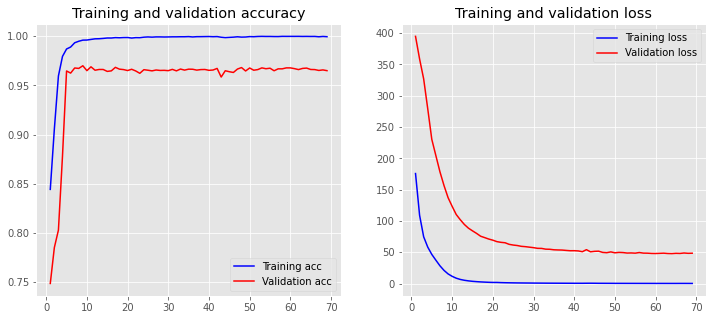

2/2 [==============================] - 3s 61ms/step
F1-score: 73.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8775510204081632,0.86,0.8686868686868686,50.0
DOC_NAME,0.7951807228915663,0.8048780487804879,0.8,82.0
PARTY,0.632,0.6370967741935484,0.6345381526104418,124.0
micro avg,0.7315175097276264,0.734375,0.732943469785575,256.0
macro avg,0.7682439144332432,0.7673249409913455,0.7677416737657702,256.0
weighted avg,0.7322280089746742,0.734375,0.7332698217110868,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3103 words (4903 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 231, 100)          800700    
                                                                 
 bidirectional_18 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 962,956
Trainable params: 962,956
Non-trainable para

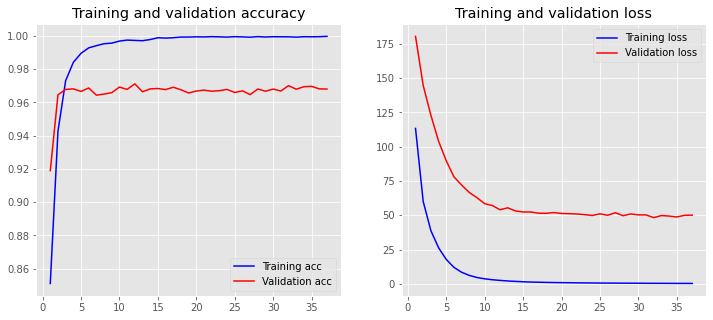

2/2 [==============================] - 3s 66ms/step
F1-score: 76.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7818181818181819,0.86,0.819047619047619,50.0
DOC_NAME,0.7976190476190477,0.8170731707317073,0.8072289156626505,82.0
PARTY,0.6762589928057554,0.7580645161290323,0.7148288973384032,124.0
micro avg,0.7338129496402878,0.796875,0.7640449438202247,256.0
macro avg,0.7518987407476617,0.8117125622869131,0.7803684773495577,256.0
weighted avg,0.7357491644671277,0.796875,0.7647809972917199,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3108 words (4926 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 231, 100)          803500    
                                                                 
 bidirectional_19 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 965,756
Trainable params: 965,756
Non-trainable para

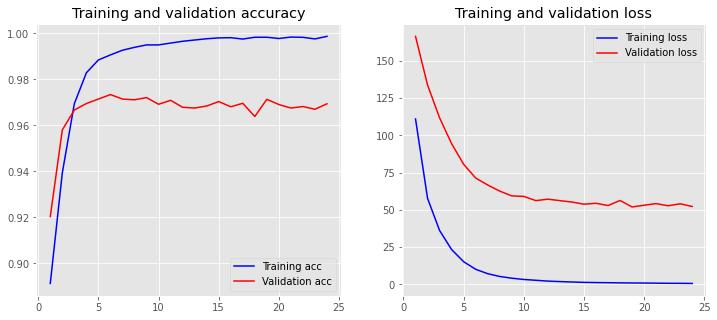

2/2 [==============================] - 3s 66ms/step
F1-score: 75.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8269230769230769,0.86,0.8431372549019608,50.0
DOC_NAME,0.7857142857142857,0.8048780487804879,0.7951807228915663,82.0
PARTY,0.6506849315068494,0.7661290322580645,0.7037037037037037,124.0
micro avg,0.723404255319149,0.796875,0.7583643122676581,256.0
macro avg,0.7544407647147374,0.8103356936795175,0.7806738938324104,256.0
weighted avg,0.7283580343030258,0.796875,0.7602380518807255,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3096 words (4935 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 231, 100)          803200    
                                                                 
 bidirectional_20 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 965,456
Trainable params: 965,456
Non-trainable para

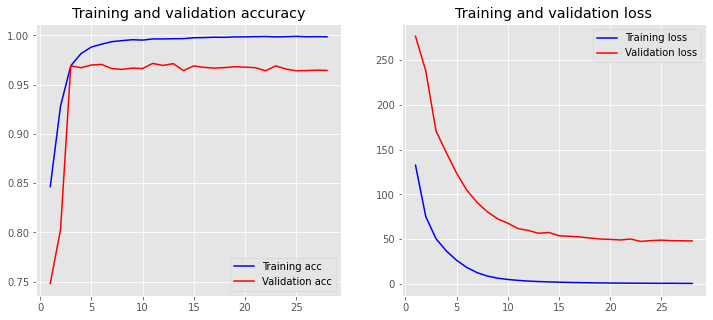

2/2 [==============================] - 3s 62ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8076923076923077,0.84,0.8235294117647058,50.0
DOC_NAME,0.7045454545454546,0.7560975609756098,0.7294117647058823,82.0
PARTY,0.6791044776119403,0.7338709677419355,0.7054263565891472,124.0
micro avg,0.7116788321167883,0.76171875,0.7358490566037735,256.0
macro avg,0.7304474132832341,0.7766561762391818,0.7527891776865784,256.0
weighted avg,0.7123683510985284,0.76171875,0.7361761855905151,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3107 words (4906 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 231, 100)          801400    
                                                                 
 bidirectional_21 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 963,656
Trainable params: 963,656
Non-trainable para

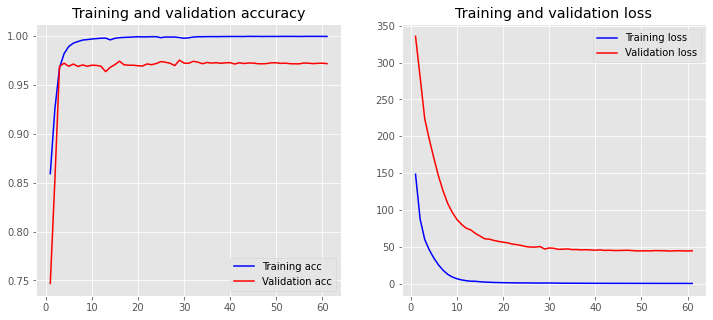

2/2 [==============================] - 3s 65ms/step
F1-score: 75.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8269230769230769,0.86,0.8431372549019608,50.0
DOC_NAME,0.7444444444444445,0.8170731707317073,0.7790697674418605,82.0
PARTY,0.6923076923076923,0.7258064516129032,0.7086614173228347,124.0
micro avg,0.7352941176470589,0.78125,0.7575757575757576,256.0
macro avg,0.7545584045584045,0.8009598741148701,0.776956146555552,256.0
weighted avg,0.735299813034188,0.78125,0.7574789039975083,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3121 words (4930 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 231, 100)          805200    
                                                                 
 bidirectional_22 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 967,456
Trainable params: 967,456
Non-trainable para

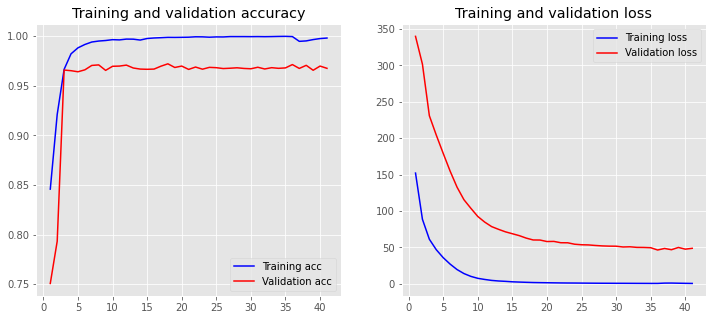

2/2 [==============================] - 3s 69ms/step
F1-score: 72.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7192982456140351,0.82,0.7663551401869159,50.0
DOC_NAME,0.7582417582417582,0.8414634146341463,0.7976878612716763,82.0
PARTY,0.5802469135802469,0.7580645161290323,0.6573426573426573,124.0
micro avg,0.6580645161290323,0.796875,0.7208480565371025,256.0
macro avg,0.68592897247868,0.8065093102543929,0.7404618862670832,256.0
weighted avg,0.6644193505487366,0.796875,0.7235884810316904,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 339
Points in y_train after augmentation: 339
Converted 3100 words (4926 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 231, 100)          802700    
                                                                 
 bidirectional_23 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 964,956
Trainable params: 964,956
Non-trainable para

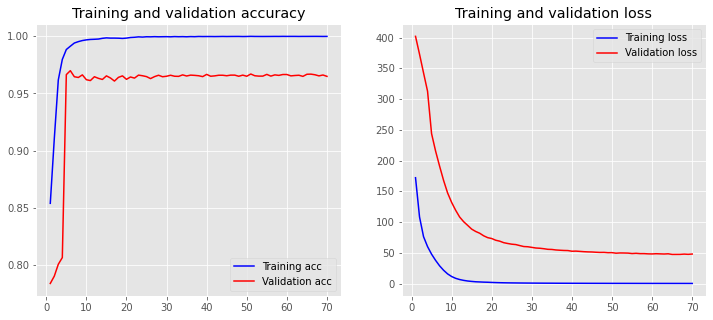

2/2 [==============================] - 3s 62ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8653846153846154,0.9,0.8823529411764707,50.0
DOC_NAME,0.7790697674418605,0.8170731707317073,0.7976190476190477,82.0
PARTY,0.55,0.6209677419354839,0.5833333333333334,124.0
micro avg,0.6798561151079137,0.73828125,0.7078651685393259,256.0
macro avg,0.731484794275492,0.7793469708890637,0.7544351073762839,256.0
weighted avg,0.6849724675760287,0.73828125,0.710373993347339,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3138 words (4975 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 231, 100)          811400    
                                                                 
 bidirectional_24 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 973,656
Trainable params: 973,656
Non-trainable para

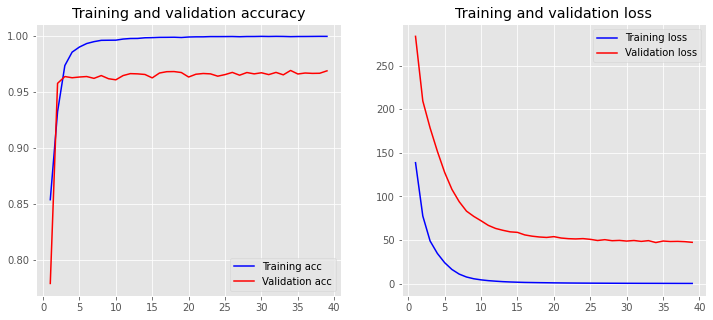

2/2 [==============================] - 3s 67ms/step
F1-score: 74.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7192982456140351,0.82,0.7663551401869159,50.0
DOC_NAME,0.8313253012048193,0.8414634146341463,0.8363636363636364,82.0
PARTY,0.6444444444444445,0.7016129032258065,0.6718146718146719,124.0
micro avg,0.7163636363636363,0.76953125,0.7419962335216573,256.0
macro avg,0.7316893304210996,0.7876921059533176,0.7581778161217413,256.0
weighted avg,0.7189246019164377,0.76953125,0.742986697250716,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3134 words (4952 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 231, 100)          808700    
                                                                 
 bidirectional_25 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 970,956
Trainable params: 970,956
Non-trainable para

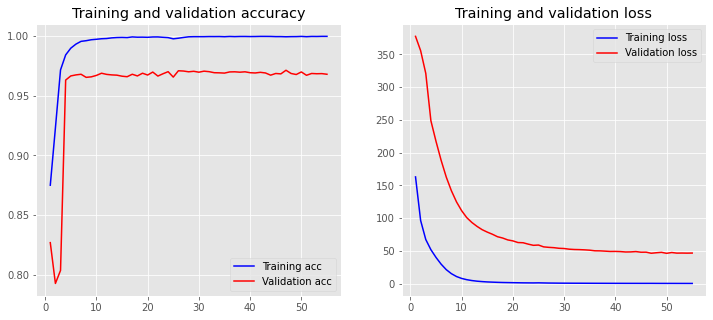

2/2 [==============================] - 3s 63ms/step
F1-score: 73.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7924528301886793,0.84,0.8155339805825242,50.0
DOC_NAME,0.8192771084337349,0.8292682926829268,0.8242424242424242,82.0
PARTY,0.6287878787878788,0.6693548387096774,0.6484375,124.0
micro avg,0.7201492537313433,0.75390625,0.7366412213740459,256.0
macro avg,0.7468392724700976,0.7795410437975346,0.7627379682749829,256.0
weighted avg,0.7217697709792859,0.75390625,0.7373860461601758,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3144 words (4977 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 231, 100)          812200    
                                                                 
 bidirectional_26 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 974,456
Trainable params: 974,456
Non-trainable para

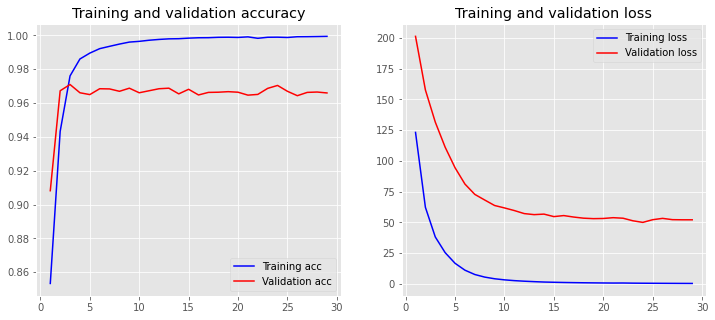

2/2 [==============================] - 3s 63ms/step
F1-score: 74.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8653846153846154,0.9,0.8823529411764707,50.0
DOC_NAME,0.7976190476190477,0.8170731707317073,0.8072289156626505,82.0
PARTY,0.6083916083916084,0.7016129032258065,0.6516853932584271,124.0
micro avg,0.7132616487455197,0.77734375,0.7439252336448597,256.0
macro avg,0.7571317571317572,0.8062286913191713,0.7804224166991828,256.0
weighted avg,0.7191974691974692,0.77734375,0.7465601832312728,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3155 words (4986 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 231, 100)          814200    
                                                                 
 bidirectional_27 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 976,456
Trainable params: 976,456
Non-trainable para

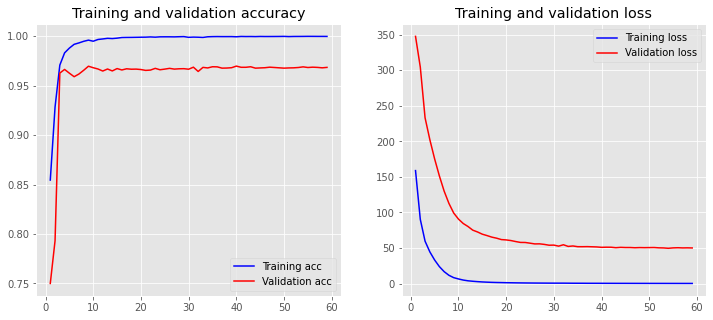

2/2 [==============================] - 3s 63ms/step
F1-score: 75.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8490566037735849,0.9,0.8737864077669903,50.0
DOC_NAME,0.7976190476190477,0.8170731707317073,0.8072289156626505,82.0
PARTY,0.6444444444444445,0.7016129032258065,0.6718146718146719,124.0
micro avg,0.7316176470588235,0.77734375,0.7537878787878789,256.0
macro avg,0.7637066986123591,0.8062286913191713,0.7842766650814376,256.0
weighted avg,0.7334714968927822,0.77734375,0.7546371514754147,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3146 words (4984 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 231, 100)          813100    
                                                                 
 bidirectional_28 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 975,356
Trainable params: 975,356
Non-trainable para

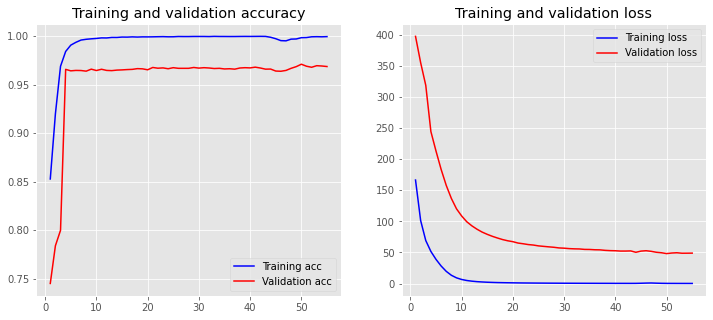

2/2 [==============================] - 3s 63ms/step
F1-score: 77.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7962962962962963,0.86,0.826923076923077,50.0
DOC_NAME,0.8607594936708861,0.8292682926829268,0.8447204968944099,82.0
PARTY,0.6690140845070423,0.7661290322580645,0.7142857142857143,124.0
micro avg,0.7490909090909091,0.8046875,0.775894538606403,256.0
macro avg,0.7753566248247417,0.8184657749803304,0.7953097627010671,256.0
weighted avg,0.7552923428699247,0.8046875,0.778065090480172,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3139 words (4960 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 231, 100)          810000    
                                                                 
 bidirectional_29 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 972,256
Trainable params: 972,256
Non-trainable para

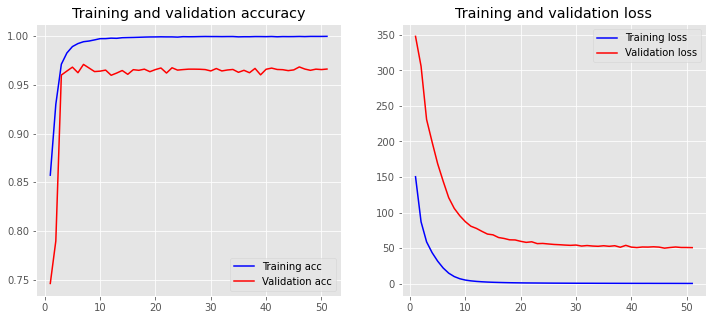

2/2 [==============================] - 3s 60ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8627450980392157,0.88,0.8712871287128714,50.0
DOC_NAME,0.8095238095238095,0.8292682926829268,0.8192771084337348,82.0
PARTY,0.609375,0.6290322580645161,0.6190476190476191,124.0
micro avg,0.7224334600760456,0.7421875,0.7321772639691715,256.0
macro avg,0.7605479691876752,0.7794335169158143,0.7698706187314084,256.0
weighted avg,0.7229715128238796,0.7421875,0.7324491565981038,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3141 words (4968 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 231, 100)          811000    
                                                                 
 bidirectional_30 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 973,256
Trainable params: 973,256
Non-trainable para

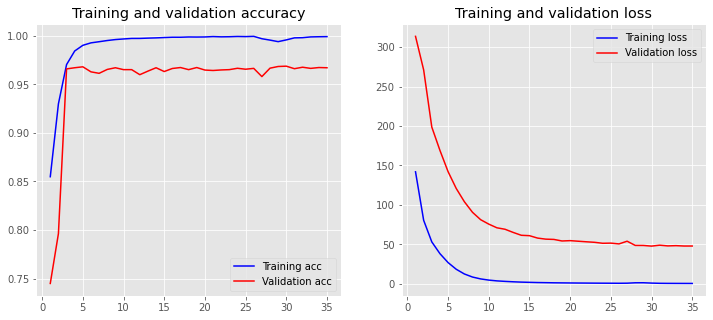

2/2 [==============================] - 3s 62ms/step
F1-score: 78.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8431372549019608,0.86,0.8514851485148515,50.0
DOC_NAME,0.8117647058823529,0.8414634146341463,0.8263473053892215,82.0
PARTY,0.7045454545454546,0.75,0.7265625,124.0
micro avg,0.7649253731343284,0.80078125,0.7824427480916031,256.0
macro avg,0.7864824717765894,0.8171544715447153,0.801464984634691,256.0
weighted avg,0.765957831996435,0.80078125,0.7829237752642919,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3135 words (4985 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 231, 100)          812100    
                                                                 
 bidirectional_31 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 974,356
Trainable params: 974,356
Non-trainable para

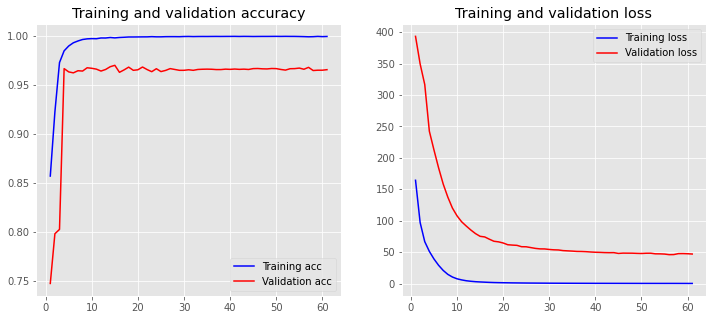

2/2 [==============================] - 3s 68ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7049180327868853,0.86,0.7747747747747747,50.0
DOC_NAME,0.7701149425287356,0.8170731707317073,0.7928994082840236,82.0
PARTY,0.6058394160583942,0.6693548387096774,0.6360153256704981,124.0
micro avg,0.6771929824561403,0.75390625,0.7134935304990757,256.0
macro avg,0.6936241304580051,0.7821426698137949,0.7345631695764322,256.0
weighted avg,0.6778102129607089,0.75390625,0.7133687132858221,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3118 words (4990 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 231, 100)          810900    
                                                                 
 bidirectional_32 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 973,156
Trainable params: 973,156
Non-trainable para

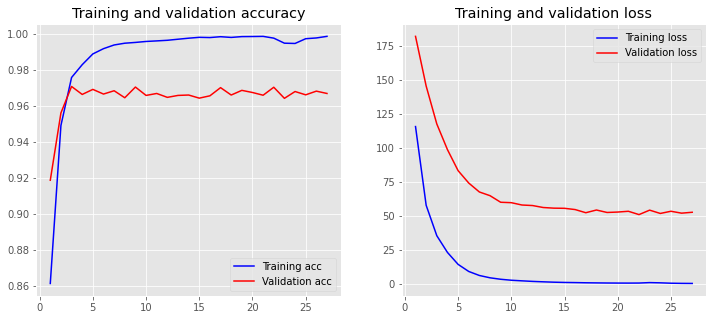

2/2 [==============================] - 3s 67ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7678571428571429,0.86,0.8113207547169812,50.0
DOC_NAME,0.7674418604651163,0.8048780487804879,0.7857142857142858,82.0
PARTY,0.625,0.7258064516129032,0.6716417910447761,124.0
micro avg,0.6958041958041958,0.77734375,0.7343173431734317,256.0
macro avg,0.7200996677740864,0.7968948334644637,0.7562256104920143,256.0
weighted avg,0.6985276941445183,0.77734375,0.7354616845858309,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 396
Points in y_train after augmentation: 396
Converted 3132 words (4986 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 231, 100)          811900    
                                                                 
 bidirectional_33 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 974,156
Trainable params: 974,156
Non-trainable para

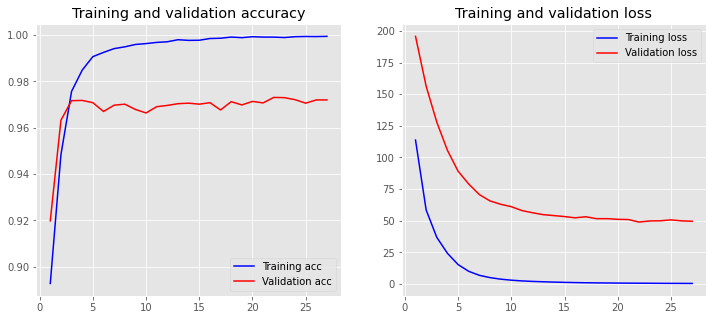

2/2 [==============================] - 3s 63ms/step
F1-score: 73.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8301886792452831,0.88,0.8543689320388349,50.0
DOC_NAME,0.7303370786516854,0.7926829268292683,0.760233918128655,82.0
PARTY,0.6293706293706294,0.7258064516129032,0.6741573033707865,124.0
micro avg,0.6982456140350877,0.77734375,0.7356746765249537,256.0
macro avg,0.7299654624225326,0.7994964594807238,0.7629200511794254,256.0
weighted avg,0.7009337205221109,0.77734375,0.7369263027596444,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3180 words (5012 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 231, 100)          819300    
                                                                 
 bidirectional_34 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 981,556
Trainable params: 981,556
Non-trainable para

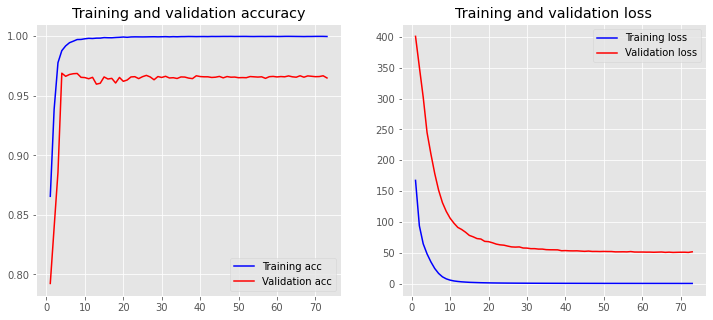

2/2 [==============================] - 3s 66ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7241379310344828,0.84,0.7777777777777777,50.0
DOC_NAME,0.8095238095238095,0.8292682926829268,0.8192771084337348,82.0
PARTY,0.5891472868217055,0.6129032258064516,0.6007905138339922,124.0
micro avg,0.6863468634686347,0.7265625,0.7058823529411764,256.0
macro avg,0.707603009126666,0.7607238394964595,0.7326151333485016,256.0
weighted avg,0.6861020019475312,0.7265625,0.7053423261557428,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3185 words (5022 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 231, 100)          820800    
                                                                 
 bidirectional_35 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 983,056
Trainable params: 983,056
Non-trainable para

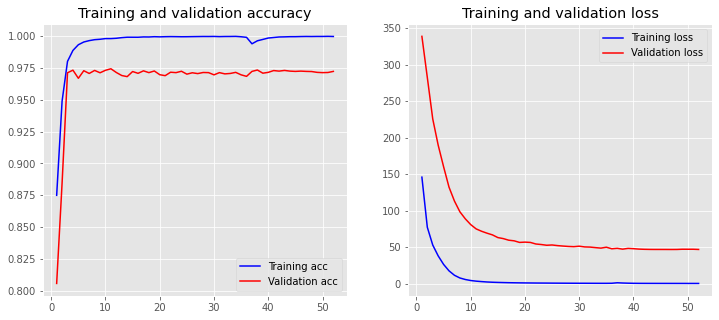

2/2 [==============================] - 3s 63ms/step
F1-score: 76.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8113207547169812,0.86,0.8349514563106797,50.0
DOC_NAME,0.85,0.8292682926829268,0.8395061728395061,82.0
PARTY,0.6793893129770993,0.717741935483871,0.6980392156862745,124.0
micro avg,0.7575757575757576,0.78125,0.7692307692307692,256.0
macro avg,0.7802366892313602,0.802336742722266,0.7908322816121535,256.0
weighted avg,0.7598059083789428,0.78125,0.7700935223963732,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3168 words (5020 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 231, 100)          818900    
                                                                 
 bidirectional_36 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 981,156
Trainable params: 981,156
Non-trainable para

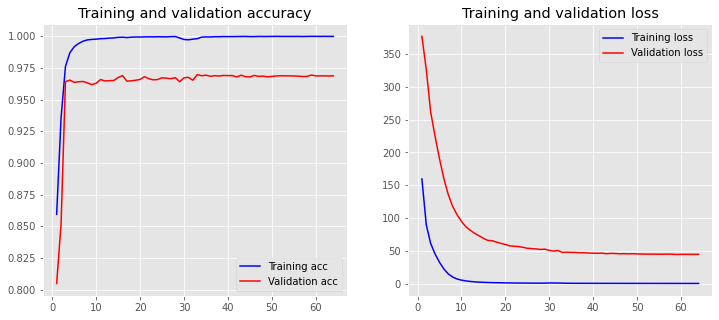

2/2 [==============================] - 3s 67ms/step
F1-score: 75.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8363636363636363,0.92,0.8761904761904761,50.0
DOC_NAME,0.7857142857142857,0.8048780487804879,0.7951807228915663,82.0
PARTY,0.6640625,0.6854838709677419,0.6746031746031745,124.0
micro avg,0.7378277153558053,0.76953125,0.7533460803059274,256.0
macro avg,0.7620468073593073,0.80345397324941,0.7819914578950723,256.0
weighted avg,0.7366816533076299,0.76953125,0.7525981903805699,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3168 words (5041 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 231, 100)          821000    
                                                                 
 bidirectional_37 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 983,256
Trainable params: 983,256
Non-trainable para

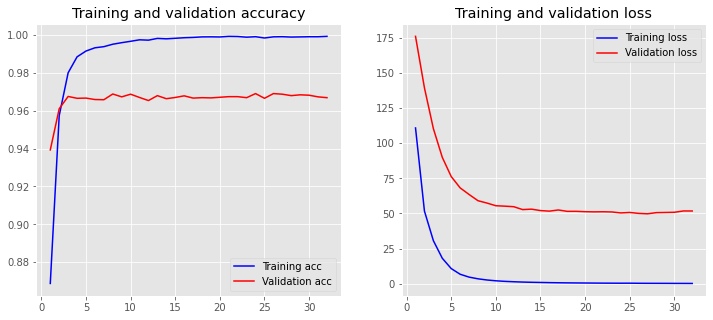

2/2 [==============================] - 3s 62ms/step
F1-score: 73.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8823529411764706,0.9,0.8910891089108911,50.0
DOC_NAME,0.7951807228915663,0.8048780487804879,0.8,82.0
PARTY,0.6029411764705882,0.6612903225806451,0.6307692307692307,124.0
micro avg,0.7148148148148148,0.75390625,0.7338403041825095,256.0
macro avg,0.7601582801795418,0.788722790453711,0.773952779893374,256.0
weighted avg,0.7190905164776753,0.75390625,0.7358196877380045,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3174 words (5013 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 231, 100)          818800    
                                                                 
 bidirectional_38 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 981,056
Trainable params: 981,056
Non-trainable para

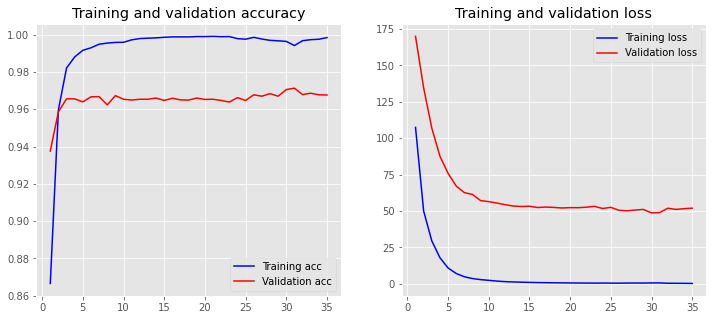

2/2 [==============================] - 3s 63ms/step
F1-score: 71.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.640625,0.82,0.7192982456140351,50.0
DOC_NAME,0.7701149425287356,0.8170731707317073,0.7928994082840236,82.0
PARTY,0.6180555555555556,0.717741935483871,0.664179104477612,124.0
micro avg,0.6677966101694915,0.76953125,0.7150635208711434,256.0
macro avg,0.6762651660280969,0.784938368738526,0.725458919458557,256.0
weighted avg,0.6711701725634578,0.76953125,0.7161752840438109,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3174 words (5025 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 231, 100)          820000    
                                                                 
 bidirectional_39 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 982,256
Trainable params: 982,256
Non-trainable para

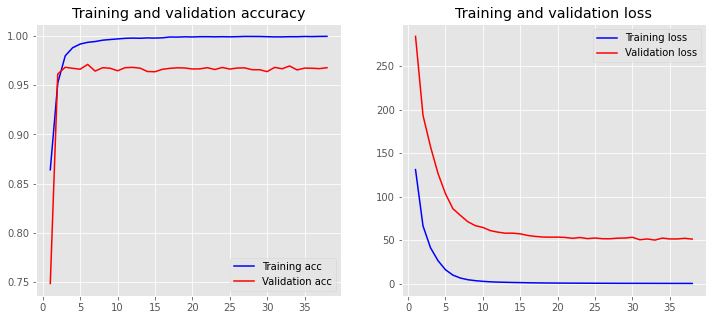

2/2 [==============================] - 3s 64ms/step
F1-score: 73.9%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8269230769230769,0.86,0.8431372549019608,50.0
DOC_NAME,0.8313253012048193,0.8414634146341463,0.8363636363636364,82.0
PARTY,0.6119402985074627,0.6612903225806451,0.6356589147286821,124.0
micro avg,0.7211895910780669,0.7578125,0.7390476190476191,256.0
macro avg,0.7567295588784528,0.7875845790715972,0.7717199353314265,256.0
weighted avg,0.7242008810932594,0.7578125,0.7404702591924719,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3169 words (5053 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 231, 100)          822300    
                                                                 
 bidirectional_40 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 984,556
Trainable params: 984,556
Non-trainable para

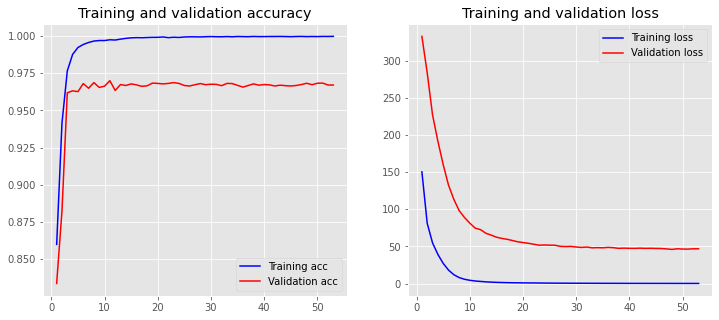

2/2 [==============================] - 3s 64ms/step
F1-score: 75.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7454545454545455,0.82,0.780952380952381,50.0
DOC_NAME,0.75,0.8048780487804879,0.7764705882352942,82.0
PARTY,0.7099236641221374,0.75,0.7294117647058822,124.0
micro avg,0.7299270072992701,0.78125,0.7547169811320755,256.0
macro avg,0.7351260698588943,0.7916260162601626,0.7622782446311858,256.0
weighted avg,0.7297002407182512,0.78125,0.7545518207282913,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3182 words (5033 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 231, 100)          821600    
                                                                 
 bidirectional_41 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 983,856
Trainable params: 983,856
Non-trainable para

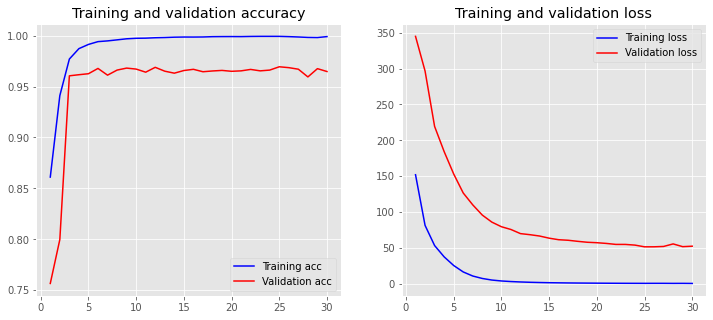

2/2 [==============================] - 3s 61ms/step
F1-score: 75.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8181818181818182,0.9,0.8571428571428572,50.0
DOC_NAME,0.8117647058823529,0.8414634146341463,0.8263473053892215,82.0
PARTY,0.6153846153846154,0.7096774193548387,0.6591760299625469,124.0
micro avg,0.7137809187279152,0.7890625,0.7495361781076068,256.0
macro avg,0.7484437131495955,0.817046944662995,0.780888730831542,256.0
weighted avg,0.7178964417935005,0.7890625,0.751388475056308,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3173 words (5020 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 231, 100)          819400    
                                                                 
 bidirectional_42 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 981,656
Trainable params: 981,656
Non-trainable para

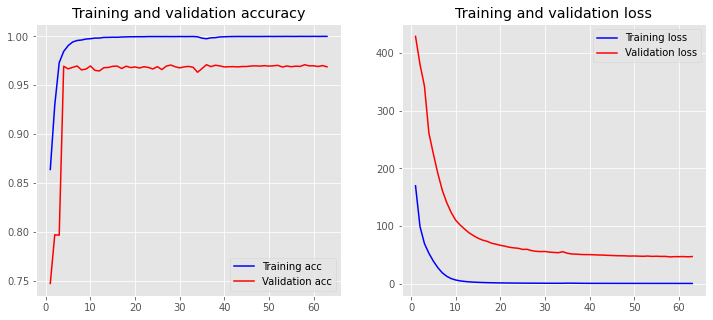

2/2 [==============================] - 3s 67ms/step
F1-score: 73.8%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7962962962962963,0.86,0.826923076923077,50.0
DOC_NAME,0.8271604938271605,0.8170731707317073,0.8220858895705522,82.0
PARTY,0.6142857142857143,0.6935483870967742,0.6515151515151515,124.0
micro avg,0.7127272727272728,0.765625,0.7382297551789077,256.0
macro avg,0.7459141681363904,0.7902071859428271,0.7668413726695936,256.0
weighted avg,0.7180211089065256,0.765625,0.7404104514797575,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 452
Points in y_train after augmentation: 452
Converted 3182 words (5015 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 231, 100)          819800    
                                                                 
 bidirectional_43 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 982,056
Trainable params: 982,056
Non-trainable para

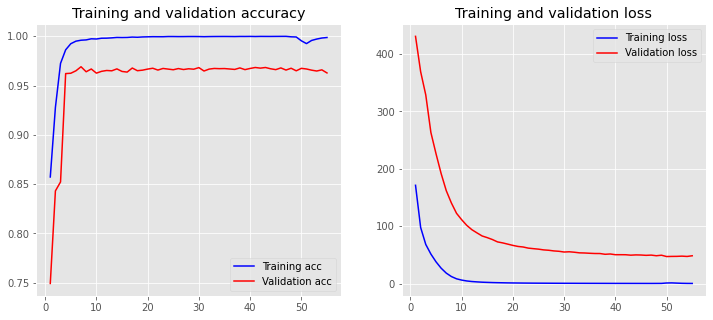

2/2 [==============================] - 3s 62ms/step
F1-score: 74.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.711864406779661,0.84,0.7706422018348624,50.0
DOC_NAME,0.8170731707317073,0.8170731707317073,0.8170731707317073,82.0
PARTY,0.6388888888888888,0.7419354838709677,0.6865671641791045,124.0
micro avg,0.7052631578947368,0.78515625,0.7430683918669131,256.0
macro avg,0.7226088221334189,0.799669551534225,0.7580941789152247,256.0
weighted avg,0.710216572504708,0.78515625,0.7447907751951253,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3298 words (5187 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 231, 100)          848600    
                                                                 
 bidirectional_44 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,010,856
Trainable params: 1,010,856
Non-trainable 

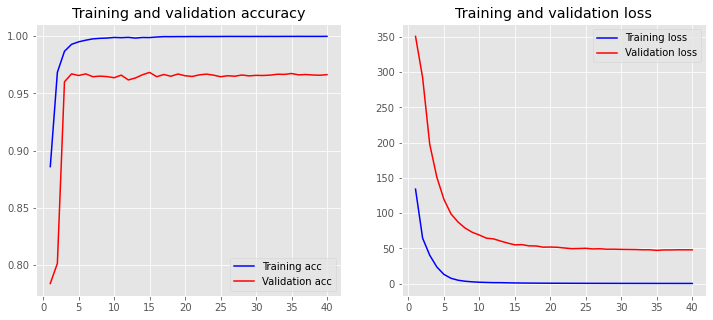

2/2 [==============================] - 3s 62ms/step
F1-score: 74.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8148148148148148,0.88,0.8461538461538461,50.0
DOC_NAME,0.8192771084337349,0.8292682926829268,0.8242424242424242,82.0
PARTY,0.6259541984732825,0.6612903225806451,0.6431372549019607,124.0
micro avg,0.7238805970149254,0.7578125,0.7404580152671756,256.0
macro avg,0.7533487072406108,0.7901862050878573,0.7711778417660771,256.0
weighted avg,0.7247647821991954,0.7578125,0.7407991824352118,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3276 words (5185 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 231, 100)          846200    
                                                                 
 bidirectional_45 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,008,456
Trainable params: 1,008,456
Non-trainable 

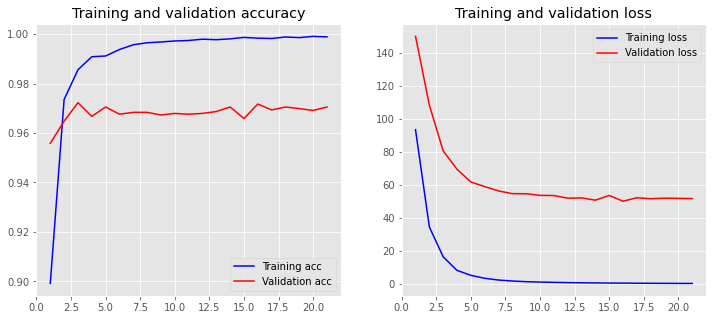

2/2 [==============================] - 3s 68ms/step
F1-score: 74.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8333333333333334,0.9,0.8653846153846153,50.0
DOC_NAME,0.8313253012048193,0.8414634146341463,0.8363636363636364,82.0
PARTY,0.5957446808510638,0.6774193548387096,0.6339622641509434,124.0
micro avg,0.7122302158273381,0.7734375,0.7415730337078652,256.0
macro avg,0.7534677717964054,0.806294256490952,0.7785701719663983,256.0
weighted avg,0.7176081319960694,0.7734375,0.7439936316631481,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3279 words (5191 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 231, 100)          847100    
                                                                 
 bidirectional_46 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,009,356
Trainable params: 1,009,356
Non-trainable 

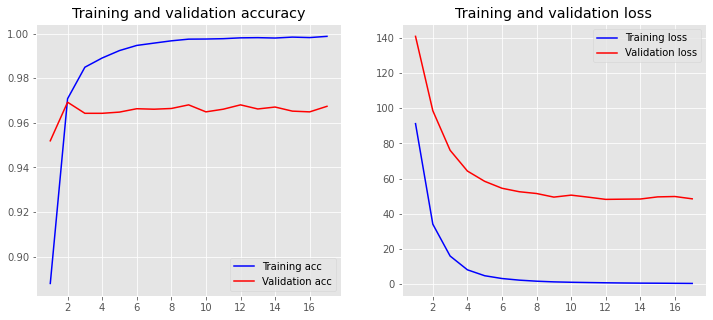

2/2 [==============================] - 3s 67ms/step
F1-score: 73.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8333333333333334,0.8,0.816326530612245,50.0
DOC_NAME,0.7857142857142857,0.8048780487804879,0.7951807228915663,82.0
PARTY,0.6434108527131783,0.6693548387096774,0.6561264822134388,124.0
micro avg,0.7241379310344828,0.73828125,0.7311411992263056,256.0
macro avg,0.7541528239202657,0.7580776291633885,0.75587791190575,256.0
weighted avg,0.7260866555924697,0.73828125,0.7319563656335433,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3296 words (5191 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 231, 100)          848800    
                                                                 
 bidirectional_47 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,011,056
Trainable params: 1,011,056
Non-trainable 

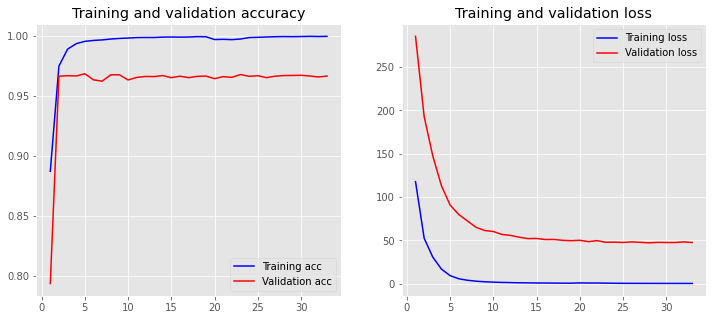

2/2 [==============================] - 3s 67ms/step
F1-score: 76.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8301886792452831,0.88,0.8543689320388349,50.0
DOC_NAME,0.8313253012048193,0.8414634146341463,0.8363636363636364,82.0
PARTY,0.6890756302521008,0.6612903225806451,0.6748971193415637,124.0
micro avg,0.7647058823529411,0.76171875,0.7632093933463796,256.0
macro avg,0.7835298702340676,0.7942512457382639,0.7885432292480118,256.0
weighted avg,0.7622011203606244,0.76171875,0.7616699514926322,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3278 words (5201 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 231, 100)          848000    
                                                                 
 bidirectional_48 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,010,256
Trainable params: 1,010,256
Non-trainable 

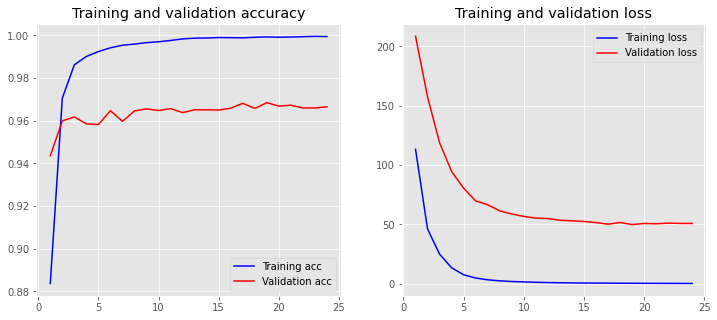

2/2 [==============================] - 3s 63ms/step
F1-score: 72.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8333333333333334,0.9,0.8653846153846153,50.0
DOC_NAME,0.8125,0.7926829268292683,0.8024691358024691,82.0
PARTY,0.5815602836879432,0.6612903225806451,0.6188679245283017,124.0
micro avg,0.6981818181818182,0.75,0.7231638418079096,256.0
macro avg,0.7424645390070923,0.7846577498033045,0.7622405585717954,256.0
weighted avg,0.7047075853280143,0.75,0.7258254786974322,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3275 words (5184 misses)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 231, 100)          846000    
                                                                 
 bidirectional_49 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,008,256
Trainable params: 1,008,256
Non-trainable 

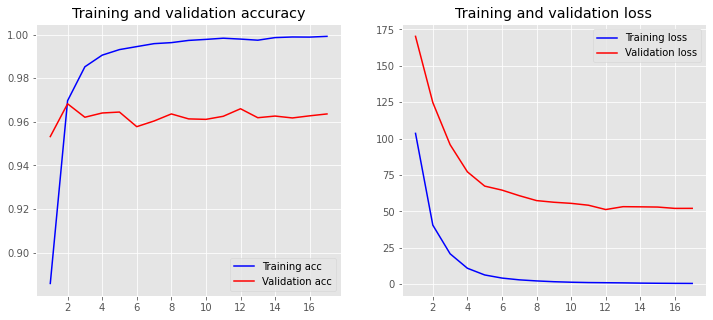

2/2 [==============================] - 3s 62ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.7543859649122807,0.86,0.8037383177570094,50.0
DOC_NAME,0.8271604938271605,0.8170731707317073,0.8220858895705522,82.0
PARTY,0.5902777777777778,0.6854838709677419,0.6343283582089553,124.0
micro avg,0.6914893617021277,0.76171875,0.7249070631970261,256.0
macro avg,0.7239414121724064,0.7875190138998164,0.7533841885121723,256.0
weighted avg,0.6982066530620532,0.76171875,0.7275573251974461,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3247 words (5195 misses)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 231, 100)          844300    
                                                                 
 bidirectional_50 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,006,556
Trainable params: 1,006,556
Non-trainable 

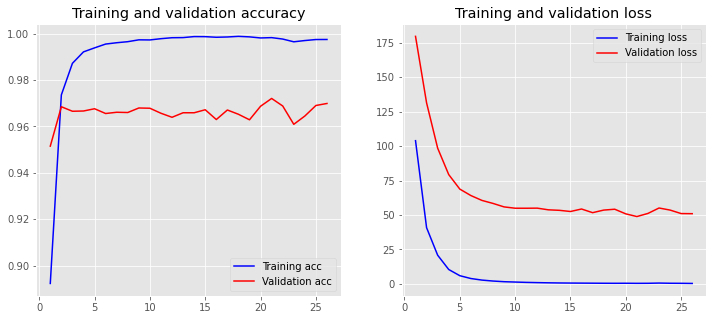

2/2 [==============================] - 3s 63ms/step
F1-score: 76.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8235294117647058,0.84,0.8316831683168315,50.0
DOC_NAME,0.8354430379746836,0.8048780487804879,0.8198757763975155,82.0
PARTY,0.6357615894039735,0.7741935483870968,0.6981818181818182,124.0
micro avg,0.7259786476868327,0.796875,0.7597765363128492,256.0
macro avg,0.7649113463811209,0.8063571990558615,0.7832469209653885,256.0
weighted avg,0.7363954562041096,0.796875,0.7632363966210285,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3276 words (5209 misses)
Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_52 (Embedding)    (None, 231, 100)          848600    
                                                                 
 bidirectional_51 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_51 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,010,856
Trainable params: 1,010,856
Non-trainable 

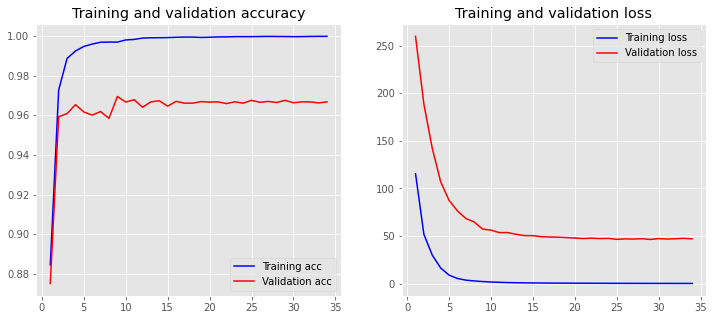

2/2 [==============================] - 3s 63ms/step
F1-score: 74.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8113207547169812,0.86,0.8349514563106797,50.0
DOC_NAME,0.825,0.8048780487804879,0.8148148148148149,82.0
PARTY,0.6323529411764706,0.6935483870967742,0.6615384615384615,124.0
micro avg,0.724907063197026,0.76171875,0.7428571428571428,256.0
macro avg,0.7562245652978173,0.7861421452924207,0.7704349108879853,256.0
weighted avg,0.7290148532880133,0.76171875,0.7445045189887423,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3282 words (5217 misses)
Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_53 (Embedding)    (None, 231, 100)          850000    
                                                                 
 bidirectional_52 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_52 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_52 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,012,256
Trainable params: 1,012,256
Non-trainable 

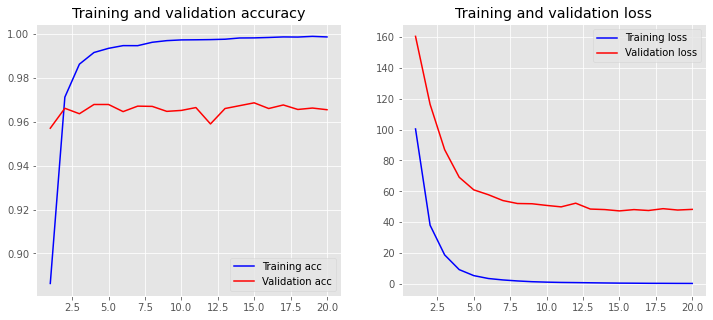

2/2 [==============================] - 3s 64ms/step
F1-score: 78.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.88,0.88,0.88,50.0
DOC_NAME,0.8292682926829268,0.8292682926829268,0.8292682926829268,82.0
PARTY,0.7154471544715447,0.7096774193548387,0.7125506072874495,124.0
micro avg,0.7843137254901961,0.78125,0.7827788649706459,256.0
macro avg,0.8082384823848239,0.8063152373459218,0.8072729666567922,256.0
weighted avg,0.7840447154471545,0.78125,0.7826417004048583,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 678
Points in y_train after augmentation: 678
Converted 3281 words (5184 misses)
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_54 (Embedding)    (None, 231, 100)          846600    
                                                                 
 bidirectional_53 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_53 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_53 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,008,856
Trainable params: 1,008,856
Non-trainable 

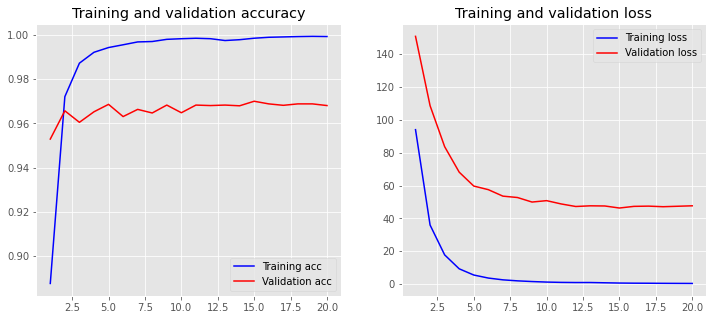

2/2 [==============================] - 3s 65ms/step
F1-score: 76.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8076923076923077,0.84,0.8235294117647058,50.0
DOC_NAME,0.8095238095238095,0.8292682926829268,0.8192771084337348,82.0
PARTY,0.6742424242424242,0.717741935483871,0.6953125,124.0
micro avg,0.7425373134328358,0.77734375,0.7595419847328245,256.0
macro avg,0.7638195138195139,0.7956700760555991,0.7793730067328135,256.0
weighted avg,0.7436391733266733,0.77734375,0.7600622792179748,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3516 words (5558 misses)
Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_55 (Embedding)    (None, 231, 100)          907500    
                                                                 
 bidirectional_54 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_54 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_54 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,069,756
Trainable params: 1,069,756
Non-trainabl

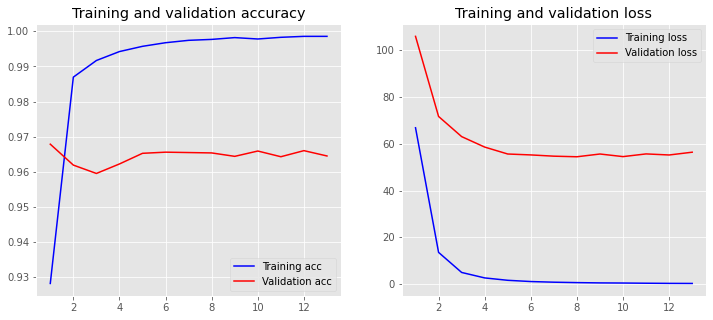

2/2 [==============================] - 3s 62ms/step
F1-score: 71.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8163265306122449,0.8,0.8080808080808082,50.0
DOC_NAME,0.8271604938271605,0.8170731707317073,0.8220858895705522,82.0
PARTY,0.6,0.6290322580645161,0.6141732283464566,124.0
micro avg,0.7115384615384616,0.72265625,0.7170542635658914,256.0
macro avg,0.7478290081464686,0.7487018095987411,0.748113308665939,256.0
weighted avg,0.7150136211892164,0.72265625,0.7186428268116652,256.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3533 words (5564 misses)
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, 231, 100)          909800    
                                                                 
 bidirectional_55 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_55 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_55 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,072,056
Trainable params: 1,072,056
Non-trainabl

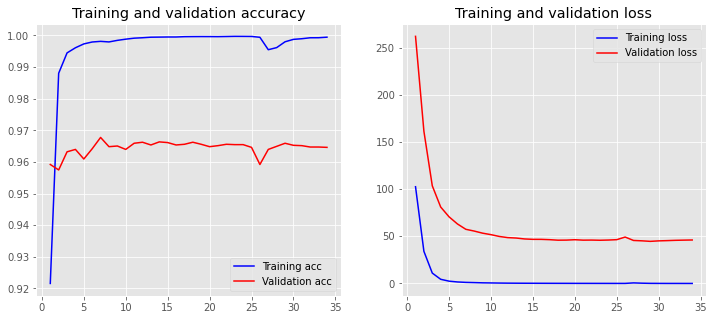

2/2 [==============================] - 3s 63ms/step
F1-score: 75.0%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8269230769230769,0.86,0.8431372549019608,50.0
DOC_NAME,0.8354430379746836,0.8048780487804879,0.8198757763975155,82.0
PARTY,0.65625,0.6774193548387096,0.6666666666666667,124.0
micro avg,0.7451737451737451,0.75390625,0.7495145631067961,256.0
macro avg,0.7728720382992534,0.7807658012063992,0.7765598993220477,256.0
weighted avg,0.7469823553128043,0.75390625,0.7502083713920351,256.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3549 words (5612 misses)
Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_57 (Embedding)    (None, 231, 100)          916200    
                                                                 
 bidirectional_56 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_56 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_56 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,078,456
Trainable params: 1,078,456
Non-trainabl

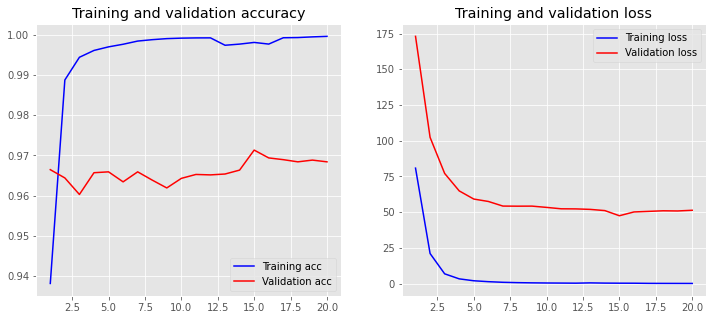

2/2 [==============================] - 3s 66ms/step
F1-score: 74.7%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8113207547169812,0.86,0.8349514563106797,50.0
DOC_NAME,0.825,0.8048780487804879,0.8148148148148149,82.0
PARTY,0.6118421052631579,0.75,0.6739130434782608,124.0
micro avg,0.7087719298245614,0.7890625,0.7467652495378928,256.0
macro avg,0.7493876199933797,0.804959349593496,0.7745597715345851,256.0
weighted avg,0.7190799171425024,0.7890625,0.7504984571158326,256.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3542 words (5598 misses)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_58 (Embedding)    (None, 231, 100)          914100    
                                                                 
 bidirectional_57 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_57 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_57 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,076,356
Trainable params: 1,076,356
Non-trainabl

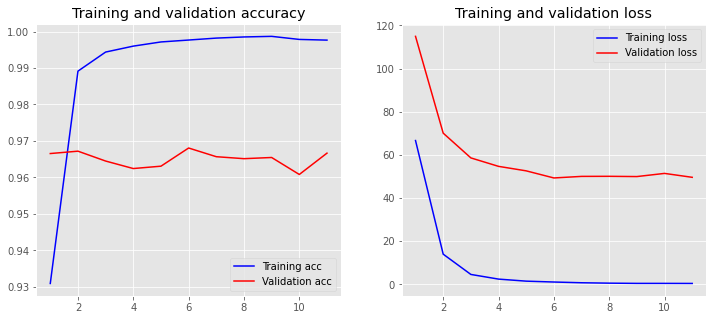

2/2 [==============================] - 3s 66ms/step
F1-score: 76.4%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.9166666666666666,0.88,0.8979591836734694,50.0
DOC_NAME,0.8354430379746836,0.8048780487804879,0.8198757763975155,82.0
PARTY,0.680327868852459,0.6693548387096774,0.6747967479674796,124.0
micro avg,0.7751004016064257,0.75390625,0.7643564356435644,256.0
macro avg,0.8108125244979364,0.7847442958300551,0.7975439026794882,256.0
weighted avg,0.776173117910009,0.75390625,0.7648537874853016,256.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3536 words (5599 misses)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_59 (Embedding)    (None, 231, 100)          913600    
                                                                 
 bidirectional_58 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_58 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_58 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,075,856
Trainable params: 1,075,856
Non-trainabl

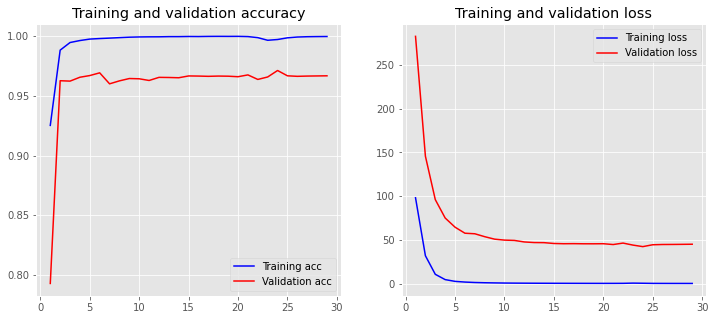

2/2 [==============================] - 3s 61ms/step
F1-score: 74.1%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8297872340425532,0.78,0.8041237113402062,50.0
DOC_NAME,0.875,0.7682926829268293,0.8181818181818181,82.0
PARTY,0.6444444444444445,0.7016129032258065,0.6718146718146719,124.0
micro avg,0.7440944881889764,0.73828125,0.7411764705882353,256.0
macro avg,0.7830772261623326,0.7499685287175453,0.7647067337788988,256.0
weighted avg,0.7544940344267139,0.73828125,0.7445395076677293,256.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3518 words (5596 misses)
Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_60 (Embedding)    (None, 231, 100)          911500    
                                                                 
 bidirectional_59 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_59 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_59 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,073,756
Trainable params: 1,073,756
Non-trainabl

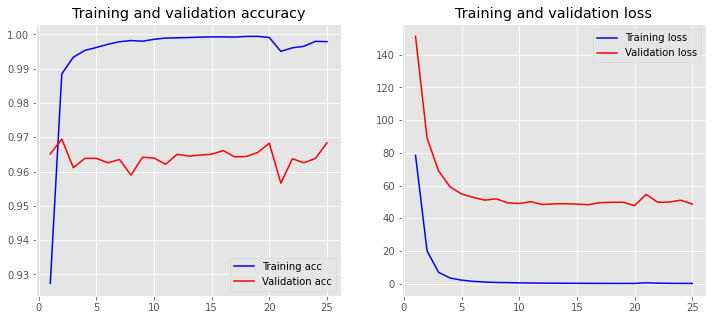

2/2 [==============================] - 3s 70ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8113207547169812,0.86,0.8349514563106797,50.0
DOC_NAME,0.8414634146341463,0.8414634146341463,0.8414634146341463,82.0
PARTY,0.5797101449275363,0.6451612903225806,0.6106870229007634,124.0
micro avg,0.7032967032967034,0.75,0.7258979206049149,256.0
macro avg,0.7441647714262212,0.7822082349855757,0.7623672979485298,256.0
weighted avg,0.7087894363549357,0.75,0.7284092330282369,256.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3488 words (5563 misses)
Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_61 (Embedding)    (None, 231, 100)          905200    
                                                                 
 bidirectional_60 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_60 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_60 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,067,456
Trainable params: 1,067,456
Non-trainabl

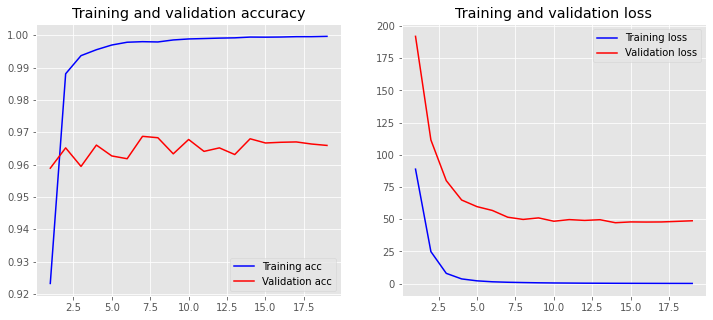

2/2 [==============================] - 3s 66ms/step
F1-score: 74.3%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8076923076923077,0.84,0.8235294117647058,50.0
DOC_NAME,0.8433734939759037,0.8536585365853658,0.8484848484848484,82.0
PARTY,0.6608695652173913,0.6129032258064516,0.6359832635983262,124.0
micro avg,0.752,0.734375,0.7430830039525692,256.0
macro avg,0.770645122295201,0.7688539207972725,0.7693325079492935,256.0
weighted avg,0.7480041717874844,0.734375,0.7406802845710363,256.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3512 words (5556 misses)
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, 231, 100)          906900    
                                                                 
 bidirectional_61 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_61 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_61 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,069,156
Trainable params: 1,069,156
Non-trainabl

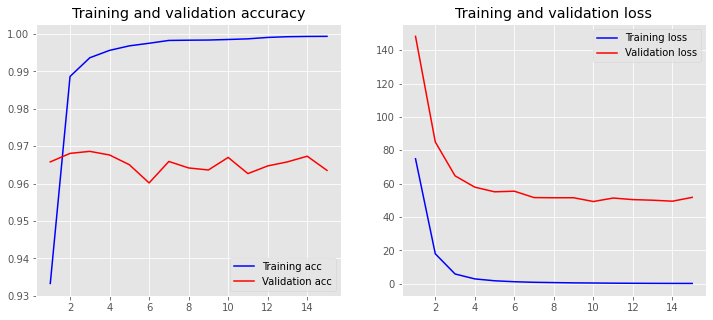

2/2 [==============================] - 4s 70ms/step
F1-score: 73.2%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8269230769230769,0.86,0.8431372549019608,50.0
DOC_NAME,0.8271604938271605,0.8170731707317073,0.8220858895705522,82.0
PARTY,0.624,0.6290322580645161,0.6265060240963856,124.0
micro avg,0.7286821705426356,0.734375,0.7315175097276265,256.0
macro avg,0.7593611902500791,0.7687018095987411,0.7639097228562995,256.0
weighted avg,0.7287082591405508,0.734375,0.7314634870227934,256.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3547 words (5613 misses)
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, 231, 100)          916100    
                                                                 
 bidirectional_62 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_62 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_62 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,078,356
Trainable params: 1,078,356
Non-trainabl

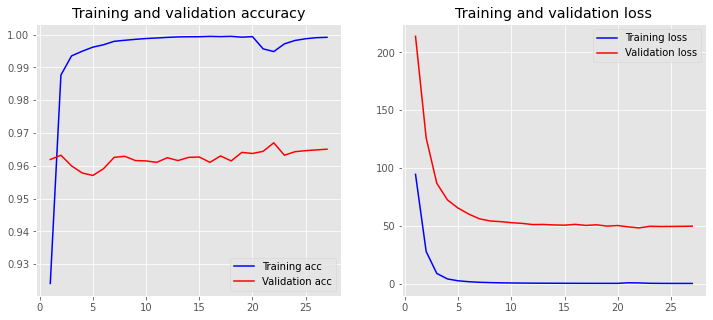

2/2 [==============================] - 3s 63ms/step
F1-score: 75.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8775510204081632,0.86,0.8686868686868686,50.0
DOC_NAME,0.8072289156626506,0.8170731707317073,0.812121212121212,82.0
PARTY,0.7053571428571429,0.6370967741935484,0.6694915254237288,124.0
micro avg,0.7745901639344263,0.73828125,0.756,256.0
macro avg,0.7967123596426523,0.7713899816417519,0.7834332020772697,256.0
weighted avg,0.7716195617930908,0.73828125,0.7540829374250984,256.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1356
Points in y_train after augmentation: 1356
Converted 3515 words (5612 misses)
Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_64 (Embedding)    (None, 231, 100)          912800    
                                                                 
 bidirectional_63 (Bidirecti  (None, 231, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_63 (TimeDi  (None, 231, 7)           1407      
 stributed)                                                      
                                                                 
 crf_63 (CRF)                (None, 231, 7)            49        
                                                                 
Total params: 1,075,056
Trainable params: 1,075,056
Non-trainabl

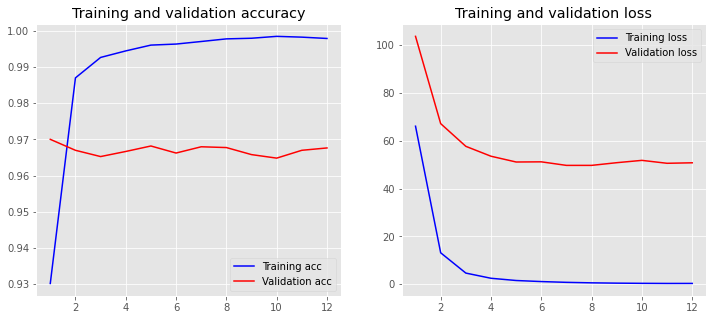

2/2 [==============================] - 3s 66ms/step
F1-score: 74.6%
Classification Report:
,precision,recall,f1-score,support
AGMT_DATE,0.8958333333333334,0.86,0.8775510204081632,50.0
DOC_NAME,0.8607594936708861,0.8292682926829268,0.8447204968944099,82.0
PARTY,0.6363636363636364,0.6209677419354839,0.6285714285714286,124.0
micro avg,0.7580645161290323,0.734375,0.7460317460317459,256.0
macro avg,0.797652154455952,0.7700786782061368,0.7836143152913339,256.0
weighted avg,0.7589181095967588,0.734375,0.7464355035492458,256.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)